In [14]:
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
from transformers import BertModel, BertTokenizerFast, AdamW
# AutoTokenizer, AutoModelForQuestionAnswering, BertTokenizer, BertForQuestionAnswering
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [16]:
def get_data(path): 
    #read each file and retrieve the contexts, qustions and answers
    with open(path, 'rb') as f:
        raw_data = json.load(f)
    contexts = []
    questions = []
    answers = []
    num_q = 0
    num_pos = 0
    num_imp = 0
    for group in raw_data['data']:
        for paragraph in group['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question       = qa['question']
                num_q  = num_q  +1
                #if qa['is_impossible'] == True:
                    #num_imp = num_imp +1
                #else:
                    #num_pos = num_pos +1
                for answer in qa['answers']:
                    contexts.append(context.lower())
                    questions.append(question.lower())
                    answers.append(answer)
    return num_q, num_pos, num_imp, contexts, questions, answers

In [17]:
num_q, num_pos, num_imp, train_contexts, train_questions, train_answers = get_data('./Spoken-SQuAD-master/spoken_train-v1.1.json')
num_questions  = num_q
num_posible = num_pos
num_imposible  = num_imp

num_q, num_pos, num_imp, valid_contexts, valid_questions, valid_answers = get_data('./Spoken-SQuAD-master/spoken_test-v1.1.json')
print(len(valid_contexts))
print(len(valid_questions))
print(len(valid_answers))
def add_answer_end(answers, contexts):
    for answer, context in zip(answers, contexts):
        answer['text'] = answer['text'].lower()
        answer['answer_end'] = answer['answer_start'] + len(answer['text'])

add_answer_end(train_answers, train_contexts)
add_answer_end(valid_answers, valid_contexts)

#Text lengths to contextx
token_lens = []

for txt in train_contexts:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens.append(len(txt.split(' ')))
  

print(max(token_lens))

17841
17841
17841
789


34
37111
['what is in front of the notre dame main building?', 'the basilica of the sacred heart at notre dame is beside to which structure?']
['architecturally the school has a catholic character. atop the main building school dome is the golden statue of the virgin mary. immediately in front of the main building in facing it is a copper statue of christ with arms appraised with the legend and the bad meow names. next to the main building is the basilica of the sacred heart. immediately behind the basilica is the grotto im mary in place of prayer and reflection. it is a replica of the grotto at lourdes france where the virgin mary reputedly appeared to st bernadette still burning eighteen fifty eight. at the end of the main drive and in a direct line that connects through three statues in the gold dome is as simple modern stone statue of mary.', 'architecturally the school has a catholic character. atop the main building school dome is the golden statue of the virgin mary. immediately

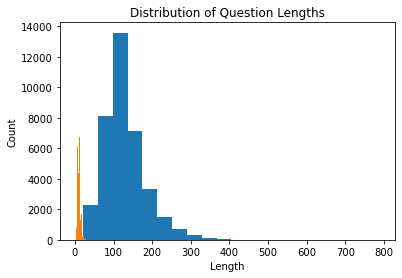

In [18]:
plt.hist(token_lens,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Context Lengths');

#Test lengths of Questions
token_lens2 = []

for txt in train_questions:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

MAX_LENGTH = 250
MODEL_PATH = "deepset/bert-base-cased-squad2"

print(train_questions[0:2])
print(train_contexts[0:2])

In [19]:
tokenizerFast = BertTokenizerFast.from_pretrained(MODEL_PATH)
train_encodings_fast = tokenizerFast(train_questions, train_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)
valid_encodings_fast = tokenizerFast(valid_questions,valid_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)

type(train_encodings_fast)

print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['input_ids'][0]))

def ret_Answer_start_and_end_train(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(train_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(train_encodings_fast['input_ids'][idx]) -  len(answer_encoding_fast['input_ids']) ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != train_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
            if match:
                ret_start = a+1
                ret_end = a+i+1
                break
    return(ret_start, ret_end)

start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encodings_fast['input_ids'])):
    s, e = ret_Answer_start_and_end_train(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1

    
train_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

def ret_Answer_start_and_end_valid(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(valid_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(valid_encodings_fast['input_ids'][idx])  -  len(answer_encoding_fast['input_ids'])   ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != valid_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
            if match:
                ret_start = a+1
                ret_end = a+i+1
                break
    return(ret_start, ret_end)

start_positions = []
end_positions = []
ctr = 0
for h in range(len(valid_encodings_fast['input_ids']) ):
    #print(h)
    s, e = ret_Answer_start_and_end_valid(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1

    
valid_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
37111
250
507
3236


In [20]:
class InputDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            'token_type_ids': torch.tensor(self.encodings['token_type_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = InputDataset(train_encodings_fast)
valid_dataset = InputDataset(valid_encodings_fast)

train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=1)

bert_model = BertModel.from_pretrained(MODEL_PATH)  #MODEL_PATH = "bert-base-uncased"

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
class QAModel(nn.Module):
    def __init__(self):
        super(QAModel, self).__init__()
        self.bert = bert_model
        self.drop_out = nn.Dropout(0.1)
        self.l1 = nn.Linear(768 * 2, 768 * 2)
        self.l2 = nn.Linear(768 * 2, 2)
        self.linear_relu_stack = nn.Sequential(
            self.drop_out,
            self.l1,
            nn.LeakyReLU(),
            self.l2 
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        model_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        hidden_states = model_output[2]
        out = torch.cat((hidden_states[-1], hidden_states[-3]), dim=-1)  # taking Start logits from last BERT layer, End Logits from third to last layer
        logits = self.linear_relu_stack(out)
        
        start_logits, end_logits = logits.split(1, dim=-1)
        
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

model = QAModel()


In [22]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)/2
    return total_loss

def focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):
    
    #calculate Probabilities by applying Softmax to the Start and End Logits. Then get 1 - probabilities
    smax = nn.Softmax(dim=1)
    probs_start = smax(start_logits)
    inv_probs_start = 1 - probs_start
    probs_end = smax(end_logits)
    inv_probs_end = 1 - probs_end
    
    #get log of probabilities. Note: NLLLoss required log probabilities. This is the Natural Log (Log base e)
    lsmax = nn.LogSoftmax(dim=1)
    log_probs_start = lsmax(start_logits)
    log_probs_end = lsmax(end_logits)
    
    nll = nn.NLLLoss()
    
    fl_start = nll(torch.pow(inv_probs_start, gamma)* log_probs_start, start_positions)
    fl_end = nll(torch.pow(inv_probs_end, gamma)*log_probs_end, end_positions)
    
    #return mean of the Loss for the start and end logits
    return ((fl_start + fl_end)/2)

optim = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)
scheduler = ExponentialLR(optim, gamma=0.9)
total_acc = []
total_loss = []


/home/psilimk/.local/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
def train_epoch(model, dataloader, epoch):
    model = model.train()
    losses = []
    acc = []
    ctr = 0
    batch_tracker = 0
    for batch in tqdm(dataloader, desc = 'Running Epoch '):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        out_start, out_end = model(input_ids=input_ids, 
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
        #loss = loss_fn(out_start, out_end, start_positions, end_positions)  # <---BASELINE.  Cross Entropy Loss is returned by Default
        loss = focal_loss_fn(out_start, out_end, start_positions, end_positions,1) #using gamma = 1
        losses.append(loss.item())
        loss.backward()
        optim.step()
        
        start_pred = torch.argmax(out_start, dim=1)
        end_pred = torch.argmax(out_end, dim=1)
            
        acc.append(((start_pred == start_positions).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum()/len(end_pred)).item())
        #ctr = ctr +1
        #if ctr==50:
        #    break
        batch_tracker = batch_tracker + 1
        if batch_tracker==250 and epoch==1:
            total_acc.append(sum(acc)/len(acc))
            loss_avg = sum(losses)/len(losses)
            total_loss.append(loss_avg)
            batch_tracker = 0
    scheduler.step()
    ret_acc = sum(acc)/len(acc)
    ret_loss = sum(losses)/len(losses)
    return(ret_acc, ret_loss)

In [24]:
def eval_model(model, dataloader):
    model = model.eval()
    losses = []
    acc = []
    ctr = 0
    answer_list=[]
    with torch.no_grad():
        for batch in tqdm(dataloader, desc = 'Running Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)
            
            out_start, out_end = model(input_ids=input_ids, attention_mask=attention_mask,token_type_ids=token_type_ids)
            # print("out_start",out_start.shape)
            start_pred = torch.argmax(out_start)
            end_pred = torch.argmax(out_end)
            answer = tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(input_ids[0][start_pred:end_pred]))
            tanswer = tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(input_ids[0][start_true[0]:end_true[0]]))
            answer_list.append([answer,tanswer])
        #ret_loss = sum(losses)/len(losses)
    return answer_list


In [ ]:
from evaluate import load
wer = load("wer")
EPOCHS = 3
model.to(device)
wer_list=[]
for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_data_loader, epoch+1)
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    answer_list = eval_model(model, valid_data_loader)
    pred_answers=[]
    true_answers=[]
    for i in range(len(answer_list)):
        if(len(answer_list[i][0])==0):
            answer_list[i][0]="$"
        if(len(answer_list[i][1])==0):
            answer_list[i][1]="$"
        pred_answers.append(answer_list[i][0])
        true_answers.append(answer_list[i][1])
    wer_score = wer.compute(predictions=pred_answers, references=true_answers)
    wer_list.append(wer_score)
print(wer_list)

tokens = tokenizerFast.tokenize("This is a sentence.")
print(tokens)
output = tokenizerFast.convert_tokens_to_string(tokens)
print(output)


Running Epoch :   8%|▊         | 190/2320 [01:06<12:19,  2.88it/s]